In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


For running the following cell (the optional extra credit task), GPU with a minimum of 19GB RAM is recommended, or system RAM may be used accordingly. Due to computational limitation in my case, which was 15GB RAM, I could not find the final result and thus could not compare it with the results of the main task; however, the code is working.

- In Google drive (My Drive) create folder 'sarvam-assignment-folder'
- Inside that folder upload files :

    en-hi.txt          ( training set ) ( file from https://dl.fbaipublicfiles.com/arrival/dictionaries/en-hi.0-5000.txt )

    en-hi.test.txt     ( testing set ) ( file from https://dl.fbaipublicfiles.com/arrival/dictionaries/en-hi.5000-6500.txt )

    cc.hi.300.vec        ( file from folder https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.vec.gz )

    cc.en.300.vec        ( file from folder https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz )

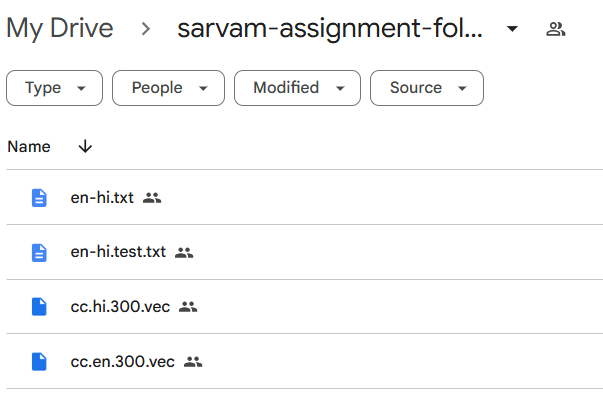

In [4]:
import io
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def load_vec(emb_path, nmax=200000):
    """
    Load word embeddings from a file and create mappings between words and indices.

    This function reads word embeddings from a text file where each line contains a word
    followed by its vector components. It creates bidirectional mappings between words and
    their indices, and returns these mappings along with the embedding matrix.

    Parameters:
        emb_path : str
            Path to the embedding file. The file should be in text format with one word and
            its embedding per line. The first line (header) is skipped.
        nmax : int, optional
            Maximum number of embeddings to load. Default is 200,000.

    Returns:
        tuple
            A tuple containing three elements:
            - word2id: A dictionary mapping words to their corresponding indices.
            - id2word: A dictionary mapping indices to their corresponding words.
            - embeddings: A numpy array of shape (n_words, n_dimensions) containing the word vectors.

    Examples:
        >>> word2id, id2word, embeddings = load_vec('cc.en.300.vec')
        >>> idx = word2id.get('hello')
        >>> print(id2word[idx])
        hello
        >>> print(embeddings.shape)
        (n_words, 300)
    """
    vectors = []
    word2id = {}
    id2word = {}

    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)  # Skip header
        for i, line in enumerate(f):
            if i >= nmax:
                break

            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')

            if word not in word2id:
                vectors.append(vect)
                word2id[word] = len(word2id)
                id2word[len(id2word)] = word

    embeddings = np.vstack(vectors).astype(np.float64)
    return word2id, id2word, embeddings

# Load and normalize embeddings with double precision
print("Loading embeddings...")
src_path = '/content/drive/MyDrive/sarvam-assignment-folder/cc.en.300.vec'
src_word2id, src_id2word, src_embeddings = load_vec(src_path)

tgt_path = '/content/drive/MyDrive/sarvam-assignment-folder/cc.hi.300.vec'
tgt_word2id, tgt_id2word, tgt_embeddings = load_vec(tgt_path)

# Normalize embeddings
src_embeddings = src_embeddings / np.linalg.norm(src_embeddings, axis=1, keepdims=True)
tgt_embeddings = tgt_embeddings / np.linalg.norm(tgt_embeddings, axis=1, keepdims=True)

# Convert to GPU tensors
src_emb = torch.from_numpy(src_embeddings).double().to(device)
tgt_emb = torch.from_numpy(tgt_embeddings).double().to(device)

class Discriminator(nn.Module):
    """
    A feed-forward neural network used as a discriminator in adversarial training.

    The network consists of multiple linear layers with LeakyReLU activations
    and dropout for regularization, outputting a single scalar value per input.

    Parameters:
        emb_dim : int
            Dimension of the input embedding vectors. Default is 300.
        hidden_size : int
            Number of neurons in the hidden layers. Default is 2048.

    Returns:
        torch.Tensor
            Scalar values for each input representing classification scores.
            Shape is (batch_size,).

    Examples:
        >>> disc = Discriminator(emb_dim=300, hidden_size=1024)
        >>> input_embeds = torch.randn(32, 300)
        >>> scores = disc(input_embeds)
        >>> print(scores.shape)
        torch.Size([32])
    """
    def __init__(self, emb_dim=300, hidden_size=2048):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(emb_dim, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.layers(x).squeeze()

class Mapping(nn.Module):
    """
    A linear transformation module with orthogonalization capability.

    This module applies a learnable linear transformation to input embeddings.
    The transformation matrix can be orthogonalized to preserve geometric
    properties of the embedding space.

    Parameters:
        emb_dim : int
            Dimension of the embedding vectors. Default is 300.

    Returns:
        torch.Tensor
            Transformed embeddings with the same dimension as inputs.
            Shape is (batch_size, emb_dim).

    Examples:
        >>> mapping = Mapping(emb_dim=300)
        >>> embeds = torch.randn(64, 300)
        >>> transformed = mapping(embeds)
        >>> print(transformed.shape)
        torch.Size([64, 300])

        # Orthogonalize the mapping matrix
        >>> mapping.orthogonalize(beta=0.001)
    """
    def __init__(self, emb_dim=300):
        super(Mapping, self).__init__()
        self.W = nn.Parameter(torch.eye(emb_dim, dtype=torch.double, device=device))

    def forward(self, x):
        return F.linear(x, self.W)

    def orthogonalize(self, beta=0.001):
        W = self.W.data
        W = (1 + beta) * W - beta * W @ W.T @ W
        self.W.data = W

def adversarial_train(src_emb, tgt_emb, n_epochs=15, batch_size=128):
    """
    Perform adversarial training to learn a mapping between source and target embedding spaces.

This function implements an adversarial approach to learn a linear mapping between two embedding spaces. It uses a discriminator to distinguish between mapped source embeddings and target embeddings, while the mapping tries to fool the discriminator. The approach follows the adversarial training paradigm from GAN (Generative Adversarial Networks) with additional orthogonalization constraints on the mapping.

Parameters:
    src_emb : torch.Tensor
        Source embeddings tensor of shape (n_words, dim).
    tgt_emb : torch.Tensor
        Target embeddings tensor of shape (n_words, dim).
    n_epochs : int, optional
        Number of training epochs. Default is 15.
    batch_size : int, optional
        Size of batches used during training. Default is 128.

Returns:
    Mapping
        The best mapping model found during training, as measured by the unsupervised criterion.

Examples:
    # Train a mapping between English and French word embeddings
    en_embeddings = load_vectors('cc.en.300.vec')
    fr_embeddings = load_vectors('cc.fr.300.vec')

    # Convert to tensors
    en_tensor = torch.tensor(np.stack(list(en_embeddings.values())))
    fr_tensor = torch.tensor(np.stack(list(fr_embeddings.values())))

    # Train the mapping
    mapping = adversarial_train(en_tensor, fr_tensor)

    # Use the mapping
    mapped_en = mapping(en_tensor)

    """
    mapping = Mapping().to(device)
    discriminator = Discriminator().double().to(device)

    map_optim = torch.optim.SGD(mapping.parameters(), lr=0.5)
    disc_optim = torch.optim.SGD(discriminator.parameters(), lr=0.5)

    map_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(map_optim, mode='max', factor=0.5, patience=2)
    disc_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(disc_optim, mode='min', factor=0.5, patience=2)

    best_score = -np.inf
    best_mapping = None

    src_ids = torch.randperm(len(src_emb))[:50000].to(device)
    tgt_ids = torch.randperm(len(tgt_emb))[:50000].to(device)

    for epoch in range(n_epochs):
        map_losses = []
        disc_losses = []

        for i in tqdm(range(0, len(src_ids), batch_size), desc=f"Epoch {epoch+1}/{n_epochs}"):
            src_batch = src_emb[src_ids[i:i+batch_size]]
            tgt_batch = tgt_emb[tgt_ids[i:i+batch_size]]

            # Train Discriminator
            for _ in range(3):
                disc_optim.zero_grad()

                mapped_src = mapping(src_batch).detach()
                real_out = discriminator(tgt_batch)
                fake_out = discriminator(mapped_src)

                loss_real = F.binary_cross_entropy_with_logits(real_out, torch.zeros_like(real_out)+0.1)
                loss_fake = F.binary_cross_entropy_with_logits(fake_out, torch.ones_like(fake_out)-0.1)
                disc_loss = (loss_real + loss_fake) / 2

                disc_loss.backward()
                torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1.0)
                disc_optim.step()
                disc_losses.append(disc_loss.item())

            # Train Mapping
            for _ in range(3):
                map_optim.zero_grad()

                mapped_src = mapping(src_batch)
                fake_out = discriminator(mapped_src)

                map_loss = F.binary_cross_entropy_with_logits(fake_out, torch.zeros_like(fake_out))

                map_loss.backward()
                torch.nn.utils.clip_grad_norm_(mapping.parameters(), 1.0)
                map_optim.step()
                mapping.orthogonalize()
                map_losses.append(map_loss.item())

        # Validate
        with torch.no_grad():
            criterion = unsupervised_criterion(mapping, src_emb, tgt_emb)
            if criterion > best_score:
                best_score = criterion
                best_mapping = Mapping().to(device)
                best_mapping.load_state_dict(mapping.state_dict())

            map_scheduler.step(criterion)
            disc_scheduler.step(criterion)

        print(f"Epoch {epoch+1} | Criterion: {criterion:.4f} | Best: {best_score:.4f}")

    return best_mapping

def unsupervised_criterion(mapping, src_emb, tgt_emb, k=10000):
    """
    Calculate an unsupervised alignment criterion based on mutual nearest neighbors in embedding spaces.

    This function evaluates how well a mapping aligns source and target embeddings by finding
    mutual nearest neighbors and computing their cosine similarity. It takes a sample of embeddings,
    applies the mapping to the source sample, and identifies pairs that are mutual nearest neighbors.
    The criterion is the mean cosine similarity of these mutual pairs.

    Parameters:
        mapping : callable
            A function that maps source embeddings to the target embedding space.
        src_emb : torch.Tensor
            Source embeddings tensor of shape (n, dim) where n is the number of embeddings
            and dim is the embedding dimension.
        tgt_emb : torch.Tensor
            Target embeddings tensor of shape (m, dim) where m is the number of embeddings
            and dim is the embedding dimension.
        k : int, optional
            Number of embeddings to consider from the beginning of both src_emb and tgt_emb.
            Default is 10,000.

    Returns:
        float
            The mean cosine similarity of mutual nearest neighbors, or 0.0 if no mutual
            nearest neighbors are found.

    Examples:
        >>> criterion_value = unsupervised_criterion(linear_mapping, en_emb, fr_emb, k=5000)
        >>> print(criterion_value)
        0.7123
    """
    src_sample = src_emb[:k]
    mapped = mapping(src_sample)

    scores = torch.mm(mapped, tgt_emb[:k].T)
    src_nn = scores.max(1)[1]
    tgt_nn = scores.max(0)[1]

    mutual = (tgt_nn[src_nn] == torch.arange(k, device=device)).nonzero().squeeze()
    if len(mutual) == 0:
        return 0.0

    X = mapped[mutual]
    Y = tgt_emb[src_nn[mutual]]
    return torch.mean(torch.sum(X * Y, dim=1)).item()

def procrustes(X, Y):
    """
    Compute the optimal orthogonal matrix for aligning two sets of embeddings using Procrustes analysis.

    This function finds the orthogonal transformation W that best maps X to Y by solving
    the orthogonal Procrustes problem through singular value decomposition.

    Parameters:
        X : torch.Tensor
            Source embeddings matrix of shape (n, d) where n is the number of vectors
            and d is the dimensionality of each vector.
        Y : torch.Tensor
            Target embeddings matrix of shape (n, d) with the same number of vectors as X.

    Returns:
        torch.Tensor
            The orthogonal transformation matrix W of shape (d, d) that minimizes
            the Frobenius norm ||XW - Y||_F subject to W'W = I.

    Examples:
        >>> src_vectors = torch.randn(100, 300)
        >>> tgt_vectors = torch.randn(100, 300)
        >>> W = procrustes(src_vectors, tgt_vectors)
        >>> print(W.shape)
        torch.Size([300, 300])
    """
    U, _, Vt = torch.svd(Y.T @ X)
    return U @ Vt

def refine_mapping(mapping, src_emb, tgt_emb, k=50000, n_iters=5):
    """
    Iteratively refine a linear mapping between source and target embeddings using mutual nearest neighbors.

    This function implements an iterative refinement procedure that:
    1. Maps source embeddings using the current transformation
    2. Identifies mutual nearest neighbors between the mapped source and target embeddings
    3. Computes a new mapping using Procrustes analysis on the subset of mutual nearest neighbors

    Parameters:
        mapping : object
            A mapping object with a callable interface for transforming vectors and a W attribute
            that stores the transformation matrix.
        src_emb : torch.Tensor
            Source embeddings matrix of shape (m, d) where m is the number of words
            and d is the dimensionality of each vector.
        tgt_emb : torch.Tensor
            Target embeddings matrix of shape (n, d) where n is the number of words
            and d is the dimensionality of each vector.
        k : int, optional
            Number of most frequent words to consider for the refinement procedure.
            Default is 50,000.
        n_iters : int, optional
            Number of refinement iterations to perform. Default is 5.

    Returns:
        object
            The mapping object with the refined transformation matrix W.

    Examples:
        >>> src_emb = torch.randn(100000, 300)
        >>> tgt_emb = torch.randn(100000, 300)
        >>> mapping = LinearMapping(300)
        >>> refined_mapping = refine_mapping(mapping, src_emb, tgt_emb)
        >>> mapped_vectors = refined_mapping(src_emb[:10])
    """
    for _ in range(n_iters):
        mapped = mapping(src_emb[:k])
        scores = torch.mm(mapped, tgt_emb[:k].T)

        row_idx = scores.max(1)[1]
        col_idx = scores.max(0)[1]
        mutual = (col_idx[row_idx] == torch.arange(k, device=device)).nonzero().squeeze()

        if len(mutual) > 10:
            W = procrustes(src_emb[mutual], tgt_emb[row_idx[mutual]])
            mapping.W.data = W.double()

    return mapping

def csls_score(src_emb, tgt_emb, k=10, batch_size=2048):
    """
    Compute Cross-domain Similarity Local Scaling (CSLS) scores between source and target embeddings.

    This function calculates the CSLS similarity scores between two sets of embeddings, which
    addresses the hubness problem in high-dimensional spaces. The CSLS similarity between vectors
    x and y is defined as: 2*cos(x,y) - rT(x) - rS(y), where rT(x) and rS(y) are the average
    cosine similarities of x and y to their k-nearest neighbors in the target and source domains.

    Parameters:
        src_emb : torch.Tensor
            Source embeddings matrix of shape (m, d) where m is the number of vectors
            and d is the dimensionality of each vector.
        tgt_emb : torch.Tensor
            Target embeddings matrix of shape (n, d) where n is the number of vectors
            and d is the dimensionality of each vector.
        k : int, optional
            Number of nearest neighbors to consider when computing average similarities.
            Default is 10.
        batch_size : int, optional
            Batch size for processing to manage memory usage. Default is 2048.

    Returns:
        torch.Tensor
            A matrix of shape (m, n) containing the CSLS similarity scores between
            all pairs of source and target embeddings.

    Examples:
        >>> src_emb = torch.randn(5000, 300)
        >>> tgt_emb = torch.randn(6000, 300)
        >>> scores = csls_score(src_emb, tgt_emb)
        >>> print(scores.shape)
        torch.Size([5000, 6000])
        >>> best_matches = scores.max(1)[1]  # Get best target match for each source word
    """
    src_avg = []
    for i in range(0, len(src_emb), batch_size):
        scores = torch.mm(src_emb[i:i+batch_size], tgt_emb.T)
        src_avg.append(scores.topk(k, dim=1)[0].mean(1))
    src_avg = torch.cat(src_avg)

    tgt_avg = []
    for i in range(0, len(tgt_emb), batch_size):
        scores = torch.mm(tgt_emb[i:i+batch_size], src_emb.T)
        tgt_avg.append(scores.topk(k, dim=1)[0].mean(1))
    tgt_avg = torch.cat(tgt_avg)

    csls_scores = []
    for i in range(0, len(src_emb), batch_size):
        batch_scores = 2 * torch.mm(src_emb[i:i+batch_size], tgt_emb.T)
        batch_scores -= src_avg[i:i+batch_size, None]
        batch_scores -= tgt_avg[None, :]
        csls_scores.append(batch_scores)

    return torch.cat(csls_scores)

def evaluate_mapping(mapping, src_emb, tgt_emb, test_pairs, method='csls', k=10):
   """
   Evaluate the quality of a cross-lingual word embedding mapping function.

   This function evaluates how well a mapping function transforms source embeddings
   to match their corresponding target embeddings. It applies the mapping to source
   embeddings and computes precision@1 (top-1 accuracy) by checking if the correct
   target word is retrieved.

   Parameters:
   -----------
   mapping : callable
       A function that maps source embeddings to the target embedding space.
   src_emb : torch.Tensor
       Source language embeddings tensor.
   tgt_emb : torch.Tensor
       Target language embeddings tensor.
   test_pairs : tuple of (list, list)
       A tuple containing (src_ids, tgt_ids) where src_ids are indices of source words
       and tgt_ids are indices of their translations in the target language.
   method : str, optional
       Similarity method to use. Either 'csls' (Cross-domain Similarity Local Scaling)
       or 'cosine' (default: 'csls').
   k : int, optional
       Number of nearest neighbors to consider for CSLS (default: 10).

   Returns:
   --------
   float
       Precision@1 (top-1 accuracy) as a percentage, indicating what percentage of
       source words were correctly mapped to their target translations.

   Examples:
   ---------
   >>> linear_mapping = lambda x: x @ W
   >>> accuracy = evaluate_mapping(linear_mapping, en_emb, fr_emb, test_pairs)
   >>> print(f"Translation accuracy: {accuracy:.2f}%")
   Translation accuracy: 78.50%
   """
    src_ids, tgt_ids = test_pairs
    mapped = mapping(src_emb[src_ids])

    if method == 'csls':
        scores = csls_score(mapped, tgt_emb, k=k)
    else:
        scores = torch.mm(mapped, tgt_emb.T)

    top1 = 0
    for i in range(len(src_ids)):
        if tgt_ids[i] in scores[i].topk(1)[1]:
            top1 += 1

    return top1 / len(src_ids) * 100

# Main pipeline
print("Starting adversarial training...")
mapping = adversarial_train(src_emb, tgt_emb)

print("Refining mapping...")
mapping = refine_mapping(mapping, src_emb, tgt_emb)

# Load and filter test dictionary
def load_test_dict(path, src_w2id, tgt_w2id, max_vocab=200000):
"""
Load word translation pairs from a file and convert them to tensor indices.

This function reads word translation pairs from a text file where each line contains a source word and its target language translation. The function filters pairs based on vocabulary inclusion and maximum vocabulary size, then converts words to their corresponding tensor indices.

Parameters:
    path : str
        Path to the translation dictionary file. The file should be in text format with one source-target word pair per line, separated by whitespace.
    src_w2id : dict
        Dictionary mapping source language words to their indices.
    tgt_w2id : dict
        Dictionary mapping target language words to their indices.
    max_vocab : int, optional
        Maximum vocabulary size to consider for both source and target words. Default is 200,000.

Returns:
    tuple
        A tuple of two tensors:
        - Source word indices as a PyTorch tensor
        - Target word indices as a PyTorch tensor
        Both elements have the same length, representing paired translations.

Examples:
    >>> src_dict = {'hello': 0, 'world': 1}
    >>> tgt_dict = {'hola': 0, 'mundo': 1}
    >>> src_indices, tgt_indices = load_test_dict('en-es.dict', src_dict, tgt_dict)
    >>> print(src_indices.shape, tgt_indices.shape)
    torch.Size([2]) torch.Size([2])
"""
    pairs = []
    with open(path) as f:
        for line in f:
            src, tgt = line.strip().split()
            if src in src_w2id and src_w2id[src] < max_vocab:
                if tgt in tgt_w2id and tgt_w2id[tgt] < max_vocab:
                    pairs.append((
                        torch.tensor(src_w2id[src]),
                        torch.tensor(tgt_w2id[tgt])
                    ))
    return zip(*pairs)

print("Evaluating...")
test_pairs = load_test_dict(
    '/content/drive/MyDrive/sarvam-assignment-folder/en-hi.test.txt',
    src_word2id, tgt_word2id
)

csls_acc = evaluate_mapping(mapping, src_emb, tgt_emb, test_pairs, method='csls')
print(f"CSLS Translation Accuracy: {csls_acc:.2f}%")

# Supervised baseline for comparison
train_pairs = load_test_dict(
    '/content/drive/MyDrive/sarvam-assignment-folder/en-hi.txt',
    src_word2id, tgt_word2id
)
X = src_emb[[s for s,t in train_pairs]]
Y = tgt_emb[[t for s,t in train_pairs]]
W_supervised = procrustes(X, Y)
mapping_supervised = Mapping()
mapping_supervised.W.data = W_supervised.double()

sup_acc = evaluate_mapping(mapping_supervised, src_emb, tgt_emb, test_pairs, method='csls')
print(f"Supervised CSLS Accuracy: {sup_acc:.2f}%")


Using device: cpu
Loading embeddings...


KeyboardInterrupt: 